# Evaluation of test year GCM-driven run

In [2]:
import valenspy as vp
from valenspy._utilities import load_yml
from valenspy.processing.select import select_point
from valenspy.diagnostic.functions import mean_bias, mean_absolute_error, root_mean_square_error, spearman_correlation, perkins_skill_score, time_series_spatial_mean
from valenspy.diagnostic.visualizations import plot_time_series
from pathlib import Path

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd


# define machine name - used for paths of (observational) datasets
machine = 'hortense'

manager = vp.InputManager(machine=machine)


## 0. Pre-defining 

In [2]:
# Define reference datasets
reference = 'ERA5'
test_set = 'EC-Earth'
domain = 'EUR11'
model = "CCLM"

variable = 'tas'
daily_statistic = "mean"

## 1. Functions

## 2. Running

In [6]:
experiment = "CB2_CCLM_EUR11_EC-Earth_test"
model = "CCLM"
variable = 'tas'
daily_statistic = "mean"
ds_exp = manager.load_data(model, [variable], freq="monthly", path_identifiers=[experiment, daily_statistic])
da_exp = ds_exp[variable]

File paths found:
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/EUR11_EC-Earth_test/CB2_CCLM_EUR11_EC-Earth_test/T_2M/monthly/T_2M_daymean_199508.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/EUR11_EC-Earth_test/CB2_CCLM_EUR11_EC-Earth_test/T_2M/monthly/T_2M_daymean_199501.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/EUR11_EC-Earth_test/CB2_CCLM_EUR11_EC-Earth_test/T_2M/monthly/T_2M_daymean_199507.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/EUR11_EC-Earth_test/CB2_CCLM_EUR11_EC-Earth_test/T_2M/monthly/T_2M_daymean_199506.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/EUR11_EC-Earth_test/CB2_CCLM_EUR11_EC-Earth_test/T_2M/monthly/T_2M_daymean_199505.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/EUR11_EC-Earth_test/CB2_CCLM_EUR11_EC-Earth_test/T_2M/monthly/T_2M_daymean_199504.nc
/dod

In [8]:
experiment = "CB2_CCLM_EUR11_ERA5_evaluation"
model = "CCLM"

variable = 'tas'
daily_statistic = "mean"
ds_eval = manager.load_data(model, [variable], freq="monthly", path_identifiers=[experiment,  'merged', 'monmean'])
da_eval = ds_eval[variable]
# for 3 years: took around 3.5 minutes: 3 for finding folder 20s for loading data

File paths found:
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_EUR11_ERA5_evaluation/CB2_CCLM_EUR11_ERA5_evaluation/T_2M/monthly/T_2M_merged_monmean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']


In [9]:
# select evaluation domain: leave out the 10 points in the outer box


def crop_outer_box(da: xr.DataArray, n_points: int = 10) -> xr.DataArray:
    """
    Crops the outer box of an xarray DataArray by removing a specified number of points
    from each edge along all dimensions.
    
    Parameters:
        da (xr.DataArray): The input DataArray.
        n_points (int): The number of points to remove from each edge. Default is 10.
    
    Returns:
        xr.DataArray: The cropped DataArray.
    """
    # Validate the DataArray has sufficient points along each dimension
    for dim in ['rlon','rlat']:
        if da.sizes[dim] <= 2 * n_points:
            raise ValueError(
                f"Dimension '{dim}' is too small to crop {n_points} points from each side."
            )
    
    # Slice each dimension
    sliced_da = da.isel({dim: slice(n_points, -n_points) for dim in da.dims})
    
    return sliced_da

# Example usage
# Assuming `da` is your xarray.DataArray
# cropped_da = crop_outer_box(da, n_points=10)


da_eval_crop = crop_outer_box(da_eval)
da_exp_crop = crop_outer_box(da_exp)

In [10]:
da_mean_eval = da_eval_crop.mean(dim=["rlat", "rlon"]).compute()
da_mean_exp  = da_exp_crop.mean(dim = ["rlat", "rlon"]).compute()

In [11]:
import xarray as xr

def rank_years(da: xr.DataArray, dim: str = "year") -> dict:
    """
    Ranks yearly values in an xarray DataArray and returns the years with the highest and lowest values.
    
    Parameters:
        da (xr.DataArray): Input DataArray with a time dimension representing years.
        dim (str): The dimension along which to rank. Default is "year".
    
    Returns:
        dict: A dictionary with the highest and lowest year and their corresponding values.
              Example: {"highest": {"year": 2000, "value": 34.5}, 
                        "lowest": {"year": 1990, "value": -23.1}}
    """
    # Ensure the DataArray has the specified dimension
    if dim not in da.dims:
        raise ValueError(f"Dimension '{dim}' not found in the DataArray.")
    
    # Identify the highest and lowest values
    highest_idx = da.argmax(dim=dim).item()  # Index of the max value
    lowest_idx = da.argmin(dim=dim).item()   # Index of the min value
    
    # Retrieve the corresponding years (assuming `dim` coordinates represent years)
    highest_year = da[dim].isel({dim: highest_idx}).item()
    lowest_year = da[dim].isel({dim: lowest_idx}).item()
    
    # Retrieve the corresponding values
    highest_value = da.isel({dim: highest_idx}).item()
    lowest_value = da.isel({dim: lowest_idx}).item()
    
    return {
        "highest": {"year": highest_year, "value": highest_value},
        "lowest": {"year": lowest_year, "value": lowest_value},
    }

# Example usage
# Assuming `da` has yearly data with dimension "year"
# result = rank_years(da, dim="year")
# print(result)


In [19]:
# rank all years. 

d_rankyears = rank_years(da_mean_eval.groupby('time.year').mean()[1:-1])
d_rankyears

{'highest': {'year': 2020, 'value': 285.7471008300781},
 'lowest': {'year': 1980, 'value': 283.83685302734375}}

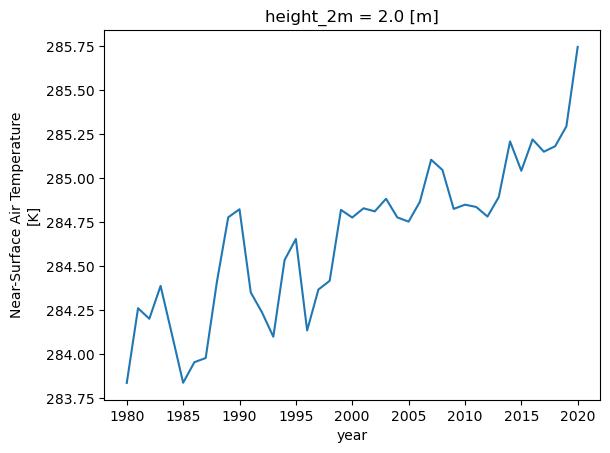

In [20]:
da_mean_eval.groupby('time.year').mean()[1:-1].plot()

In [22]:
da_mean_eval_highyear = da_mean_eval.sel(time=da_mean_eval.time.dt.year.isin([d_rankyears['highest']['year']]))
#da_mean_eval_lowyear = da_mean_eval.sel(time=da_mean_eval.time.dt.year.isin([d_rankyears['lowest']['year']]))

In [ ]:
# load daily values

variable = 'tas'
daily_statistic = "mean"
ds_eval_highyear = manager.load_data(model, [variable], period = [int(d_rankyears['highest']['year']),int(d_rankyears['highest']['year'])], freq="monthly", path_identifiers=[experiment, daily_statistic])
da_mean_eval_highyear = crop_outer_box(ds_eval_highyear[variable]).mean(dim=('rlon','rlat'))



File paths found:
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_EUR11_ERA5_evaluation/CB2_CCLM_EUR11_ERA5_evaluation/T_2M/monthly/T_2M_daymean_202002.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_EUR11_ERA5_evaluation/CB2_CCLM_EUR11_ERA5_evaluation/T_2M/monthly/T_2M_daymean_202005.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_EUR11_ERA5_evaluation/CB2_CCLM_EUR11_ERA5_evaluation/T_2M/monthly/T_2M_daymean_202012.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_EUR11_ERA5_evaluation/CB2_CCLM_EUR11_ERA5_evaluation/T_2M/monthly/T_2M_daymean_202006.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_EUR11_ERA5_evaluation/CB2_CCLM_EUR11_ERA5_evaluation/T_2M/monthly/T_2M_daymean_202001.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_EUR11_ERA5_eval

ValueError: Resulting object does not have monotonic global indexes along dimension time

In [21]:

ds_eval_lowyear = manager.load_data(model, [variable], period = [int(d_rankyears['lowest']['year']),int(d_rankyears['lowest']['year'])], freq="monthly", path_identifiers=[experiment, daily_statistic])
da_mean_eval_lowyear = crop_outer_box(ds_eval_lowyear[variable]).mean(dim=('rlon','rlat'))

File paths found:
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_EUR11_ERA5_evaluation/CB2_CCLM_EUR11_ERA5_evaluation/T_2M/monthly/T_2M_daymean_198009.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_EUR11_ERA5_evaluation/CB2_CCLM_EUR11_ERA5_evaluation/T_2M/monthly/T_2M_daymean_198011.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_EUR11_ERA5_evaluation/CB2_CCLM_EUR11_ERA5_evaluation/T_2M/monthly/T_2M_daymean_198005.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_EUR11_ERA5_evaluation/CB2_CCLM_EUR11_ERA5_evaluation/T_2M/monthly/T_2M_daymean_198003.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_EUR11_ERA5_evaluation/CB2_CCLM_EUR11_ERA5_evaluation/T_2M/monthly/T_2M_daymean_198006.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_EUR11_ERA5_eval

In [ ]:
time_index = pd.to_datetime(da_mean_exp['time'].values)
doy = xr.DataArray(time_index.dayofyear, coords={'time': da_mean_exp['time']}, name="DOY")


da_mean_exp = da_mean_exp.assign_coords(DOY=doy)
da_mean_eval_lowyear = da_mean_eval_lowyear
da_mean_eval_highyear = da_mean_eval_highyear.assign_coords(DOY=doy)

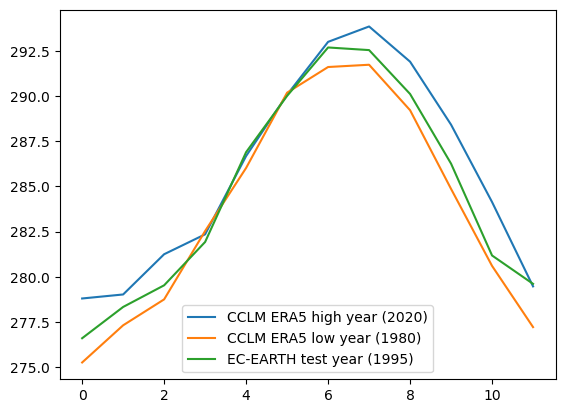

In [32]:
import matplotlib.pyplot as plt 

plt.plot(da_mean_eval_highyear.values)
plt.plot(da_mean_eval_lowyear.groupby('time.month').mean().values)
plt.plot(da_mean_exp.groupby('time.month').mean().values)

plt.legend(['CCLM ERA5 high year (2020)', 'CCLM ERA5 low year (1980)', 'EC-EARTH test year (1995)'])


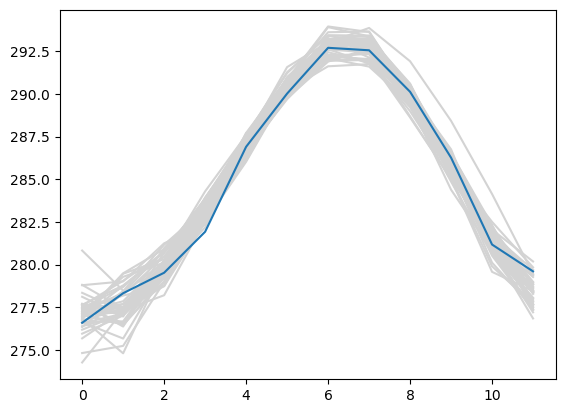

In [37]:
import matplotlib.pyplot as plt 

for year, da_eval_year in da_mean_eval.groupby('time.year'):

    plt.plot(da_eval_year.values, color="lightgrey")
plt.plot(da_mean_exp.groupby('time.month').mean().values)


## 2. Calculation and visualisation of time series
in this example, the reference data is split up for each year. Each year is plot in a spaghetti plot, where the test year is also included.
Additionally, the P5, P50 and P95 of the reference data is included for every day of every year.

In [10]:
def select_year(da : xr.Dataset, year: int):
    """
    Select single year in dataset

    """

    



In [11]:
import matplotlib.pyplot as plt

In [ ]:
def get_spaghetti_GLUE(da_eval: xr.Dataset, da_exp: xr.Dataset, variable: str): 

    plt.figure(figsize = (20,5))
    # Exctract unique years
    years_eval = np.unique(pd.to_datetime(da_eval.time).year)
    years_exp = np.unique(pd.to_datetime(da_exp.time).year)

    # Loop over all years:
    for yr in years_eval:
        ds_year = da_eval.sel(time=da_eval.time.dt.year.isin([yr]))
        ds_year["time"] = pd.to_datetime(ds_year["time"]).strftime("%m-%d")
        da_year = ds_year[variable]
        da_year.plot.scatter(x = "time", y = variable)

    for yr in years_exp:
        ds_year = da_exp.sel(time=da_exp.time.dt.year.isin([yr]))
        ds_year["time"] = pd.to_datetime(ds_year["time"]).strftime("%m-%d")
        da_year = ds_year[variable]
        da_year.plot.line(x = "time", y = variable)
    
    return ds_year


<xarray.Dataset> Size: 11kB
Dimensions:       (time: 365, bnds: 2)
Coordinates:
  * time          (time) datetime64[ns] 3kB 1995-01-01T11:30:00 ... 1995-12-3...
    lon           float32 4B dask.array<chunksize=(), meta=np.ndarray>
    lat           float32 4B dask.array<chunksize=(), meta=np.ndarray>
    rlon          float32 4B -8.685
    rlat          float32 4B 1.045
    height_2m     float32 4B 2.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds     (time, bnds) datetime64[ns] 6kB dask.array<chunksize=(30, 2), meta=np.ndarray>
    rotated_pole  (time) |S1 365B b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    tas           (time) float32 1kB dask.array<chunksize=(30,), meta=np.ndarray>
Attributes: (12/18)
    CDI:               Climate Data Interface version 2.3.0 (https://mpimet.m...
    Conventions:       CF-1.4
    source:            cosmo6.00_clm2, int2lm3.0_clm1
    institution:       KU Leuven, Leuven, BELGIUM
    title:             EUR11_NU_TT_EC
    project_id:        CORDEXbe2
    ...                ...
    history:           Tue Nov 19 14:16:43 2024: cdo mergetime daily/T_2M_day...
    frequency:         day
    CDO:               Climate Data Operators version 2.3.0 (https://mpimet.m...
    freq:              monthly
    path_identifiers:  ['CB2_CCLM_EUR11_EC-Earth_test', 'mean']
    dataset:           CCLM

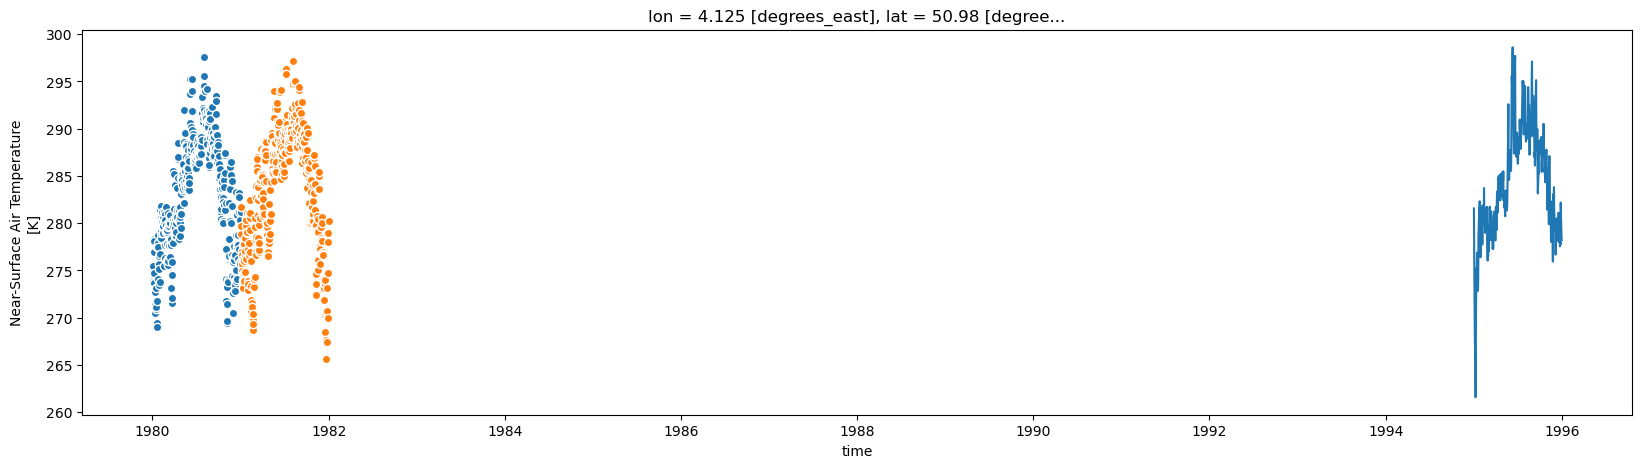

In [29]:
get_spaghetti_GLUE(da_point_eval, da_point_exp, variable = 'tas')

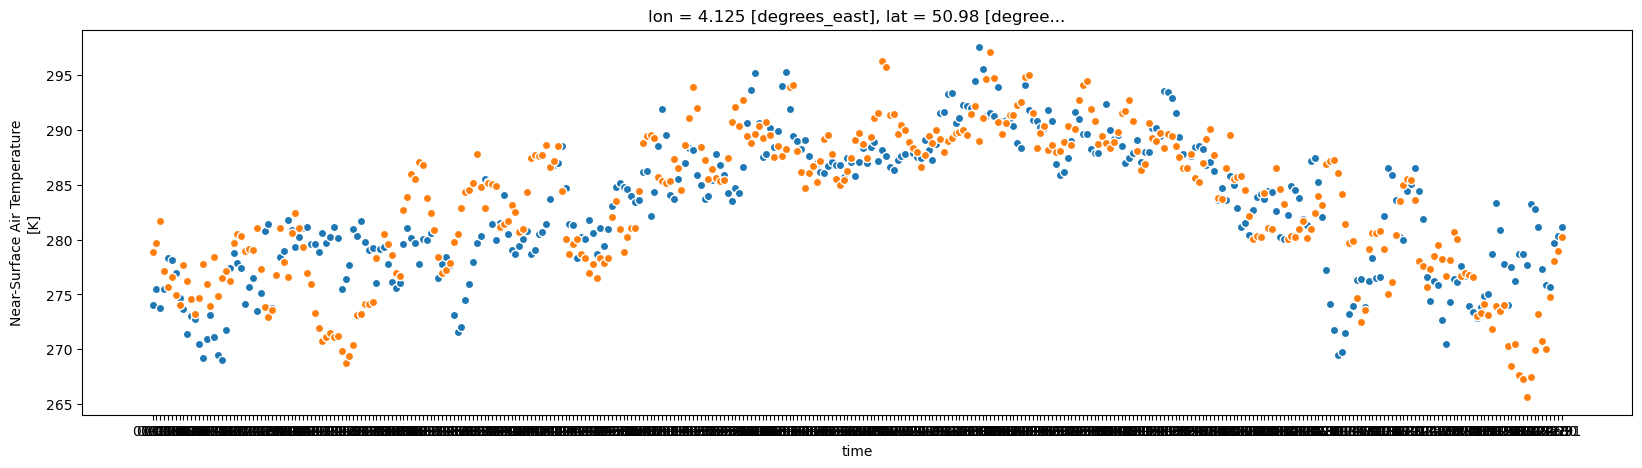

In [30]:
    plt.figure(figsize = (20,5))
    
    # Exctract unique years
    years_eval = np.unique(pd.to_datetime(da_eval.time).year)
    years_exp = np.unique(pd.to_datetime(da_exp.time).year)

    # Loop over all years:
    for yr in years_eval:
        ds_year = da_eval.sel(time=da_eval.time.dt.year.isin([yr]))
        ds_year["time"] = pd.to_datetime(ds_year["time"]).strftime("%m-%d")
        da_year = ds_year[variable]
        da_year.plot.scatter(x = "time", y = variable)



## 3. Calculation of P5, P50, P95 for each year 
In this example, the P5, P50 and P95 for each year are calculated for the reference run and the test year. 